In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from adjustText import adjust_text
from Modules import plot_ax_violin
from Modules import read_data

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2
plt.rcParams['xtick.major.width'] = .5
plt.rcParams['ytick.major.width'] = .5

In [2]:
def read_lin_data():
    df_lin = read_data.read_labeled_tpm_data('Lab_Pvalb')
    fname = 'Datasets/Lab_Pvalb-transcriptional_labels.tsv'
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    df_labels = pd.read_csv(fname, **kwargs)
    
    df_labels = df_labels.loc[df_labels.Age>20]
    
    df_lin = df_lin.loc[:,df_lin.columns.get_level_values('Cell').isin(df_labels.index)].copy()
    
    return df_lin

def read_olm_data():
    df_olm = read_data.read_labeled_tpm_data('Lab_OLM')
    df_olm = df_olm.xs('SST-OLM', level='CellType', axis=1).copy()
    
    arrays = [df_olm.columns, ['OLM']*df_olm.shape[1]]
    names = ('Cell', 'CellType')
    
    df_olm.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df_olm

def read_foldy_data():
    df_foldy = read_data.read_labeled_tpm_data('GSE75386')
    df_foldy = df_foldy.xs('CA1 pyramidal cell', level='CellType', axis=1).copy()
    
    arrays = [df_foldy.columns, ['PYR']*df_foldy.shape[1]]
    names = ('Cell', 'CellType')
    
    df_foldy.columns = pd.MultiIndex.from_arrays(arrays, names=names)
    
    return df_foldy

def get_target_genes():
    genes = [['Gad1', 'Gad2', 'Slc6a1'],
             ['Lhx6', 'Satb1', 'Sox6'],
             ['Prox1', 'Htr3a'],
             ['Neurod1', 'Neurod2', 'Neurod6', 'Nrn1', 'Slc17a6', 'Slc17a7'],
             ['Pvalb', 'Sst'],
            ]
    
    return genes

def read_tpm_data():
    df_lin = read_lin_data()
    df_olm = read_olm_data()
    df_foldy = read_foldy_data()
    
    df_lab = pd.concat((df_lin, df_olm, df_foldy), axis=1)
    
    return df_lab

def read_sequencing_data(dataset, celltypes=[], age=0, trim_type=0, drop=[], trim_by='.'):
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    base_name = 'References/%s-sequence.tsv'
    df = pd.read_csv(base_name % dataset, **kwargs)
    if len(celltypes) > 0:
        df = df.loc[df.CellType.isin(celltypes),:]
    if len(drop) > 0:
        for drop_type in drop:
            df = df.loc[~df.CellType.str.startswith(drop_type),:]
    
    if age > 0:
        df_labels = pd.read_csv('Datasets/%s-labels.tsv' % dataset, **kwargs)
        df_labels = df_labels.loc[df_labels.Age>age]
        df = df.loc[df.index.isin(df_labels.index)]
        
    if trim_type > 0:
        separated = df.CellType.str.split(trim_by, expand=True).fillna('')
        base = separated[0]
        if trim_type > 1:
            for i in range(1, trim_type):
                base += trim_by + separated[i]
        df.CellType = base
    
    converter = {'CA1 fast-spiking interneuron':'CA1 FS INT',
                 'CA1 regular-spiking interneuron':'CA1 RS INT',
                 'CA1 pyramidal cell':'CA1 PYR',
                 'Subiculum burst-spiking pyramidal cell':'Subiculum BS PYR',
                 'Subiculum regular-spiking pyramidal cell':'Subiculum RS PYR',
                 'Layer_2/3_Pyramidal':'L2/3 PYR',
                 'Layer_I_Astrocyte':'L1 Astrocyte',
                 'Layer_I_Interneuron':'L1 INT'
                }
    df.CellType = [converter.get(cell,cell) for cell in df.CellType]
    
    celltypes, counts = np.unique(df.CellType, return_counts=True)
    celltypes = celltypes[counts>4]
    df = df.loc[df.CellType.isin(celltypes)]
    
    return df

def get_sequencing_data():
    df_olm = read_sequencing_data('Lab_OLM', celltypes=['SST-OLM'])
    df_pvalb = read_sequencing_data('Lab_Pvalb', age=21, drop=['UCn'])
    df_cadwell = read_sequencing_data('Cadwell')
    df_fuzik = read_sequencing_data('GSE70844')
    df_harris = read_sequencing_data('GSE99888', trim_type=1)
    df_foldy = read_sequencing_data('GSE75386', drop=['hippocampus'])
    df_munoz = read_sequencing_data('GSE119248')
    df_zeisel = read_sequencing_data('GSE60361')
    df_gouwens = read_sequencing_data('Gouwens', drop=['Unknown'], trim_type=1, trim_by=' ')
    df_tasic = read_sequencing_data('GSE115746', drop=['Unknown', 'Low'], trim_type=1, trim_by=' ')
    
    dfs = (df_pvalb, df_olm, df_foldy, df_cadwell, df_munoz, df_fuzik, df_gouwens, df_zeisel, df_harris, df_tasic)
    celltypes = [celltype for df in dfs for celltype in np.unique(df.CellType)]
    
    datasets = ['This study\nGSE142546',
                'Winterer et al. (2019)\nGSE124847',
                'Földy et al. (2016)\nGSE75386',
                'Cadwell et al. (2016)\nE-MTAB-4092',
                'Muñoz-Manchado et al.\n(2018) GSE119248',
                'Fuzik et al. (2016)\nGSE70844',
                'Gouwens et al. (2020)\nGSE?????',
                'Zeisel et al. (2015)\nGSE60361',
                'Harris et al. (2018)\nGSE99888',
                'Tasic et al. (2018)\nGSE115746'
               ]
    methods = ['Patch-seq'] * 7 + ['FACS-based'] * 3
    sizes = [np.unique(df.CellType).size for df in dfs]
    
    df = pd.concat(dfs, axis=0)
    df.set_index('CellType', inplace=True)
    
    for column in df.columns:
        if column.endswith('(%)'):
            continue
        elif column.endswith('(K)'):
            df[column] = np.log10(1e3 * df[column])
        elif column.endswith('(M)'):
            df[column] = np.log10(1e6 * df[column])
            
    df.columns = df.columns.str.replace('(K)', 'log10')
    df.columns = df.columns.str.replace('(M)', 'log10')
    
    return df, celltypes, datasets, methods, sizes

def get_volcano_data():
    # read edgeR data
    kwargs = {'sep':'\t', 'header':0, 'index_col':0}
    fname = 'Differential/edgeR/General/Sst-OLM vs Pvalb.txt'
    df = pd.read_csv(fname, **kwargs)
    df.sort_values('PValue', inplace=True)
    
    # convert to volcano plot dataframe
    df['Signif'] = np.logical_and(np.abs(df.logFC)>1, df.FDR<.05)
    df['Yval'] = -np.log10(df.PValue)
    df['Color'] = df.Signif.map({False:'#999999', True:'#FFAA66'})
    df['Size'] = df.Signif.map({False:4, True:16})
    df = df.loc[:,['logFC', 'Yval', 'Signif', 'Color', 'Size']].copy()
    df.columns = ['Xval', 'Yval', 'Signif', 'Color', 'Size']
    
    return df

def label_genes(ax, df, up_label, down_label):
    kwargs = {'ha':'left', 'va':'bottom', 'fontsize':6, 'color':'#000000', 'zorder':2}
    texts = [ax.text(df.loc[gene, 'Xval'], df.loc[gene, 'Yval'], gene, **kwargs) for gene in up_label]
    kwargs['ha'] = 'right'
    texts += [ax.text(df.loc[gene, 'Xval'], df.loc[gene, 'Yval'], gene, **kwargs) for gene in down_label]
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5), ax=ax)
    
    return

def plot_volcano(ax, df):
    # do scatter plot
    inds = ~df.Signif
    ax.scatter(df.loc[inds, 'Xval'], df.loc[inds, 'Yval'],
               color=df.loc[inds, 'Color'], s=df.loc[inds, 'Size'], zorder=0)
    inds = df.Signif
    ax.scatter(df.loc[inds, 'Xval'], df.loc[inds, 'Yval'],
               color=df.loc[inds, 'Color'], s=df.loc[inds, 'Size'], zorder=0)
    
    # adjust axes
    ax.tick_params(size=2, labelsize=6)
    ax.set_xlabel('Fold change (log2-based)', fontsize=8)
    ax.set_ylabel(r'$\it{p}$-value (-log10-based)', fontsize=8)
    
    # label genes
    up_label = df.loc[np.logical_and(df.Signif, df.Xval>0),'Yval'].nlargest(10).index
    down_label = df.loc[np.logical_and(df.Signif, df.Xval<0),'Yval'].nlargest(10).index
    label_genes(ax, df, up_label, down_label)
    
    # make minor adjustments to plot
    top = df.Yval.max()*1.05
    ax.set_ylim(0,top)
    ax.plot([0,0], [0,top], linewidth=1, color='#999999', linestyle='dashed', zorder=1)
    ax.text(.17, .02, 'Enriched\nin SST-OLM', fontsize=8, ha='center', va='bottom', transform=ax.transAxes)
    ax.text(.88, .02, 'Enriched\nin PV', fontsize=8, ha='center', va='bottom', transform=ax.transAxes)
    
    return

def plot_violins(fig, df, celltypes, datasets, methods, sizes, axbg):
    left = .10
    right = .90
    dw = .06
    params = {'left':left,
              'right':right,
              'row_count':1,
              'rotation':90,
              'ticklabels':celltypes,
              'show_violin':True,
              'show_error':False,
              'show_box':False,
              'show_signif':False,
              'show_scatter':False,
              'height':.05,
              'dw':dw,
              'dh':.02,
              'ticksize':6,
              'ylabel_coords':(-.03,.5),
              'labelsize':5,
              'alpha':1,
              'precision':10,
              'connect':True,
              'ticklabel_loc':'BOTTOM'
             }
    
    # generate figure
    args = (fig, .875, df, celltypes)
    bot = plot_ax_violin.plot_generated_electrophys(*args, **params)
    
    
    totals = [0] + list(np.cumsum(sizes))
    top = .88
    left += dw
    width = right - left
    dw = width / sum(sizes)
    
    for method in set(methods):
        inds = [ind for ind, met in enumerate(methods) if met == method]
        start, end = totals[inds[0]], totals[inds[-1]+1]
        xstart = left + dw * (start+.25)
        xend = left + dw * (end-.25)
        axbg.plot([xstart, xend], [top, top], linewidth=1, color='black')
        axbg.text((xstart+xend)/2, top, method, rotation=0, ha='center', va='bottom', fontsize=10)
    
    top = bot - .08
    totals = np.cumsum(sizes)
    rotations = [90]*len(sizes)
    
    start = 0
    for dataset, rotation, total in zip(datasets, rotations, totals):
        xstart = left + dw * start + dw *.25
        xend = left + dw * total - dw * .25
        axbg.plot([xstart, xend], [top, top], linewidth=1, color='black')
        axbg.text((xstart+xend)/2 + .005, top-.002, dataset, rotation=rotation, ha='center', va='top', fontsize=7)
        start = total
    
    return

def get_barshift(n):
    assert n > 0
    
    if n == 1:
        return [0], 0.8
    
    Width = 1.6 / (3*n-1)
    shifts = np.linspace(-.4+Width/2, .4-Width/2, n)
    
    return shifts, Width

def do_heat_map(df, genes, titles, fig, celltypes=['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC', 'PYR', 'OLM']):
    genelist = sorted({gene for gene_set in genes for gene in gene_set})
    df = np.log2(1+df.loc[genelist, df.columns.get_level_values('CellType').isin(celltypes)])
    Highest = df.values.max()
    
    Top = .310
    H = .009
    Left = .53
    Right = .85
    Width = (Right - Left - .01*6) / 7
    highest = df.values.max()
    
    bargroups = [['vAAC', 'vBIC', 'hBIC', 'vBC', 'hBC'],['PYR']]
    barcolors = ['black','gray']
    barlabels = ['All PV-INs', 'PYR']
    
    for row, (gene_set, title) in enumerate(zip(genes, titles)):
        Height = H * len(gene_set)
        Bottom = Top - Height
        
        fig.text(.45, Bottom+Height/2, title, rotation=90, ha='left', va='center', fontsize=7)
        
        for col, celltype in enumerate(celltypes):
            left = Left + (Width+.01)*col
            ax = fig.add_axes([left, Bottom, Width, Height])
            ax.set_xticks([])
            datalist = df.loc[gene_set, df.columns.get_level_values('CellType')==celltype]
            pcol = ax.pcolor(datalist, vmin=0, vmax=Highest, cmap=mpl.cm.Reds)
            
            if col == 0:
                ax.set_yticks(np.arange(datalist.shape[0])+.5)
                ax.set_yticklabels(gene_set, fontsize=7)
            else:
                ax.set_yticks([])
            ax.axis([0, datalist.shape[1], datalist.shape[0], 0])
            
            if row == 0:
                ax.set_title(celltype, fontsize=8)
                
        ax = fig.add_axes([Right+.01, Bottom, .9-Right+.01, Height])
        ax.set_yticks([])
        ax.axis([0, highest*1.03, len(gene_set), 0])
        if row == 0:
            ax.xaxis.tick_top()
            ax.tick_params(axis='x', size=1, labelsize=7)
            ax.set_title('Log2 average TPM', fontsize=7)
        else:
            ax.set_xticks([])
            ax.spines['top'].set_visible(False)
            
        yvals = np.arange(len(gene_set))+.5
        
        shifts, height = get_barshift(len(bargroups))
        
        for num, (group, color, shift, label) in enumerate(zip(bargroups, barcolors, shifts, barlabels)):
            xvals = df.loc[gene_set, df.columns.get_level_values('CellType').isin(group)].values.mean(axis=1)
            ax.barh(yvals+shift, xvals, height=height, color=color, label=label)
        
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        Top = Bottom - H

    ax.legend(ncol=2, loc='upper right', bbox_to_anchor=(1,0), fontsize=7)
    cax = fig.add_axes([Left, Top-0.5*H, 2*Width, H])
    fig.colorbar(pcol, cax=cax, orientation='horizontal')
    cax.tick_params(labelsize=7)
    
    return Top

In [3]:
df_seq, celltypes, datasets, methods, sizes = get_sequencing_data()
df_volc = get_volcano_data()
df_tpm = read_tpm_data()

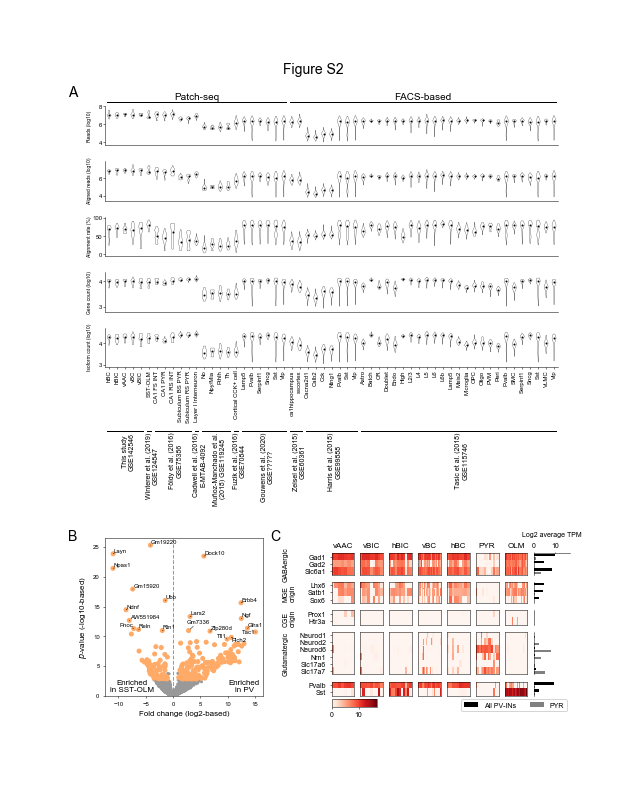

In [4]:
fig = plt.figure(figsize=(8.5,11))
fig.text(.10, .90, 'A', fontsize=14, ha='left', va='top')
fig.text(.10, .34, 'B', fontsize=14, ha='left', va='top')
fig.text(.43, .34, 'C', fontsize=14, ha='left', va='top')
fig.suptitle('Figure S2', fontsize=14, y=.93)

axbg = fig.add_axes([0,0,1,1], frameon=False)
axbg.set_xticks([])
axbg.set_yticks([])
axbg.axis([0,1,0,1])
plot_violins(fig, df_seq, celltypes, datasets, methods, sizes, axbg)

ax = fig.add_axes([.16, .13, .2585, .19975])
plot_volcano(ax, df_volc)

genes = get_target_genes()
titles = ['GABAergic', 'MGE\norigin', 'CGE\norigin', 'Glutamatergic', '']
do_heat_map(df_tpm, genes, titles, fig)
fig.savefig('Figures/Figure S2.pdf')
plt.show()
plt.close()